In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
from datetime import datetime, timedelta
import statsmodels.api as sm
import matplotlib.pyplot as plt
import yfinance as yf


In [5]:
end_date = datetime.today()
start_date = datetime(2000, 1, 1)

spx = yf.download('^GSPC', start=start_date, end=end_date, progress=False)
hist_close = spx['Close']
hist_ret = hist_close / hist_close.shift(1) - 1.0
hist_ret.dropna(inplace=True)
hist_ret = hist_ret * 100.0
print(hist_ret.describe())

Ticker        ^GSPC
count   6559.000000
mean       0.031362
std        1.218477
min      -11.984055
25%       -0.472123
50%        0.064071
75%        0.589109
max       11.580037


In [ ]:
#Gaussian mixture model

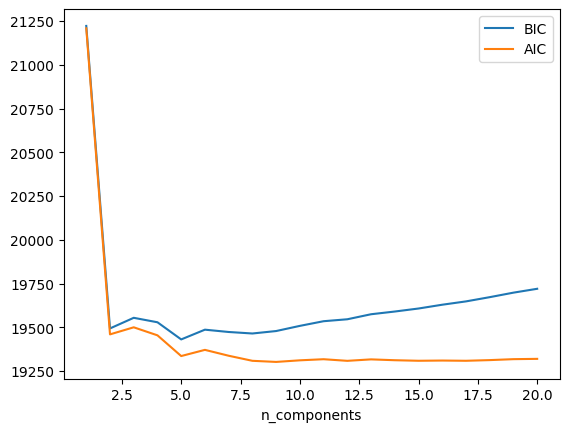

In [9]:

from sklearn.mixture import GaussianMixture

X = hist_ret.values.reshape(-1, 1)

n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X) for n in n_components]

plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In [ ]:
#We may choose two or three states based on the AIC graph. Two states could be explained as high and low vol regimes; 
#while three states hopefully can coincide with uptrend, downtrend and sideways

In [10]:
# Here I choose 2 states
gmm = GaussianMixture(n_components=2, covariance_type='full')
gmm.fit(X)
labels = gmm.predict(X)

In [11]:

# the result suggests first state is low vol, second state is high vol.
print(gmm.means_, gmm.covariances_) 

[[-0.18807459]
 [ 0.08911283]] [[[5.11214996]]

 [[0.51373365]]]


In [14]:

gmm.predict_proba(X)

array([[9.99986308e-01, 1.36915367e-05],
       [7.67343603e-02, 9.23265640e-01],
       [7.64493507e-02, 9.23550649e-01],
       ...,
       [8.03431312e-02, 9.19656869e-01],
       [9.73487670e-02, 9.02651233e-01],
       [1.02458103e-01, 8.97541897e-01]], shape=(6559, 2))

In [15]:
# save for later
gmm_regimes = gmm.predict(X)     

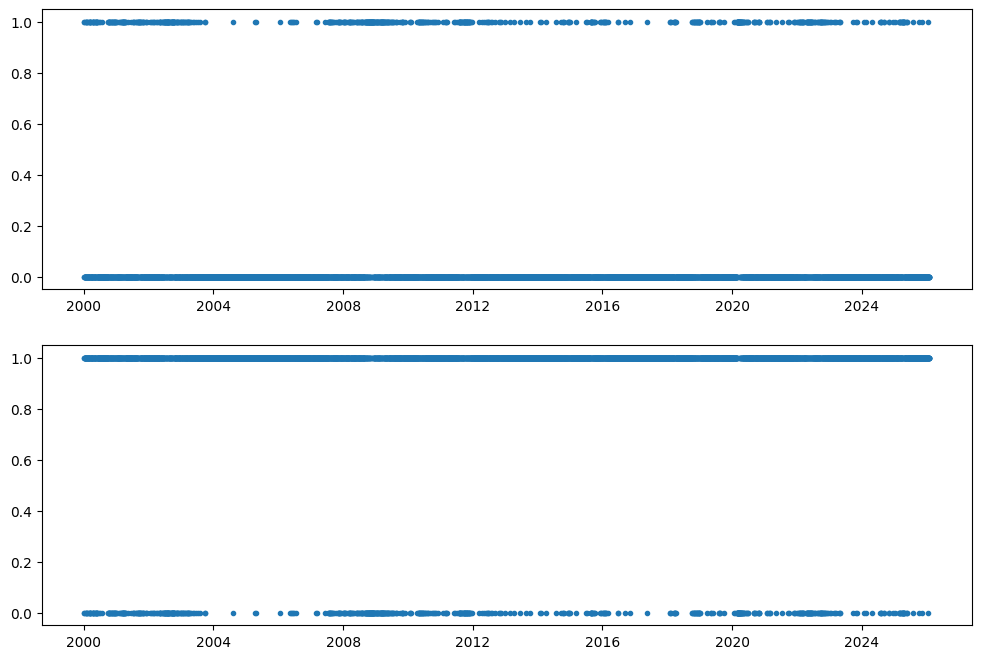

In [16]:

first_state = [1 if r == 0 else 0 for r in gmm_regimes]
second_state = [1 if r == 1 else 0 for r in gmm_regimes]
fig, axes = plt.subplots(2, figsize=(12, 8))
axes[0].plot(hist_ret.index, first_state, '.', label='first regime')
axes[1].plot(hist_ret.index, second_state, '.', label='second regime')
plt.show()

In [17]:
print(np.sum(first_state), np.sum(second_state), hist_ret.shape[0])

754 5805 6559


In [18]:
#Markov Regime Switching Model

In [20]:


from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

model = MarkovRegression(hist_ret, k_regimes=2, trend='n', switching_variance=True)
results = model.fit()
print(results.summary())

/opt/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                        Markov Switching Model Results                        
Dep. Variable:                  ^GSPC   No. Observations:                 6559
Model:               MarkovRegression   Log Likelihood               -9282.662
Date:                Mon, 02 Feb 2026   AIC                          18573.324
Time:                        19:57:56   BIC                          18600.479
Sample:                             0   HQIC                         18582.712
                               - 6559                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.5081      0.016     32.324      0.000       0.477       0.539
                             Regime 1 parameters    

In [21]:
# result suggest first regime is low vol; second regime is high vol
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                  ^GSPC   No. Observations:                 6559
Model:               MarkovRegression   Log Likelihood               -9282.662
Date:                Mon, 02 Feb 2026   AIC                          18573.324
Time:                        19:58:28   BIC                          18600.479
Sample:                             0   HQIC                         18582.712
                               - 6559                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.5081      0.016     32.324      0.000       0.477       0.539
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         3.8298      0.157     24.460      0.000       3.523       4.137
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9898      0.002    498.098      0.000       0.986       0.994
p[1->0]        0.0243      0.005      5.086      0.000       0.015       0.034
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

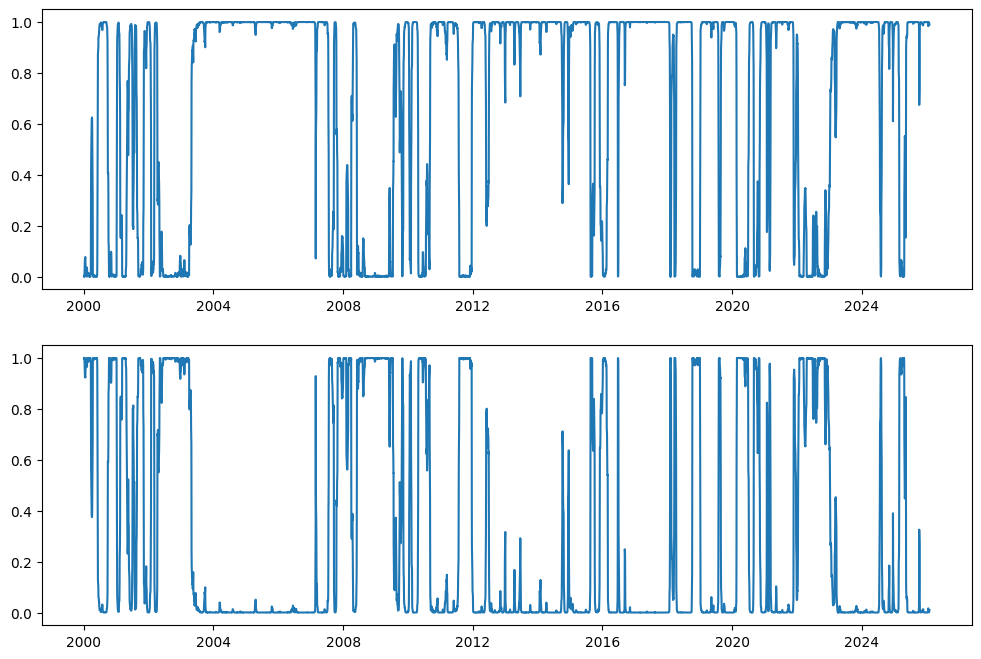

In [22]:

# Regime switch model has better results; which is expected.
# Gaussian mixture doesn't consider time sequence of historical returns.
fig, axes = plt.subplots(2, figsize=(12, 8))
axes[0].plot(res.smoothed_marginal_probabilities[0], label='first regime')
axes[1].plot(res.smoothed_marginal_probabilities[1], label='second regime')
plt.show()

In [23]:
print(np.sum(res.smoothed_marginal_probabilities[0] > 0.5), np.sum(res.smoothed_marginal_probabilities[1] > 0.5), hist_ret.shape[0])


4617 1942 6559


In [ ]:
#Evaluation

In [24]:
vix = yf.download('^VIX', start=start_date, end=end_date, progress=False)

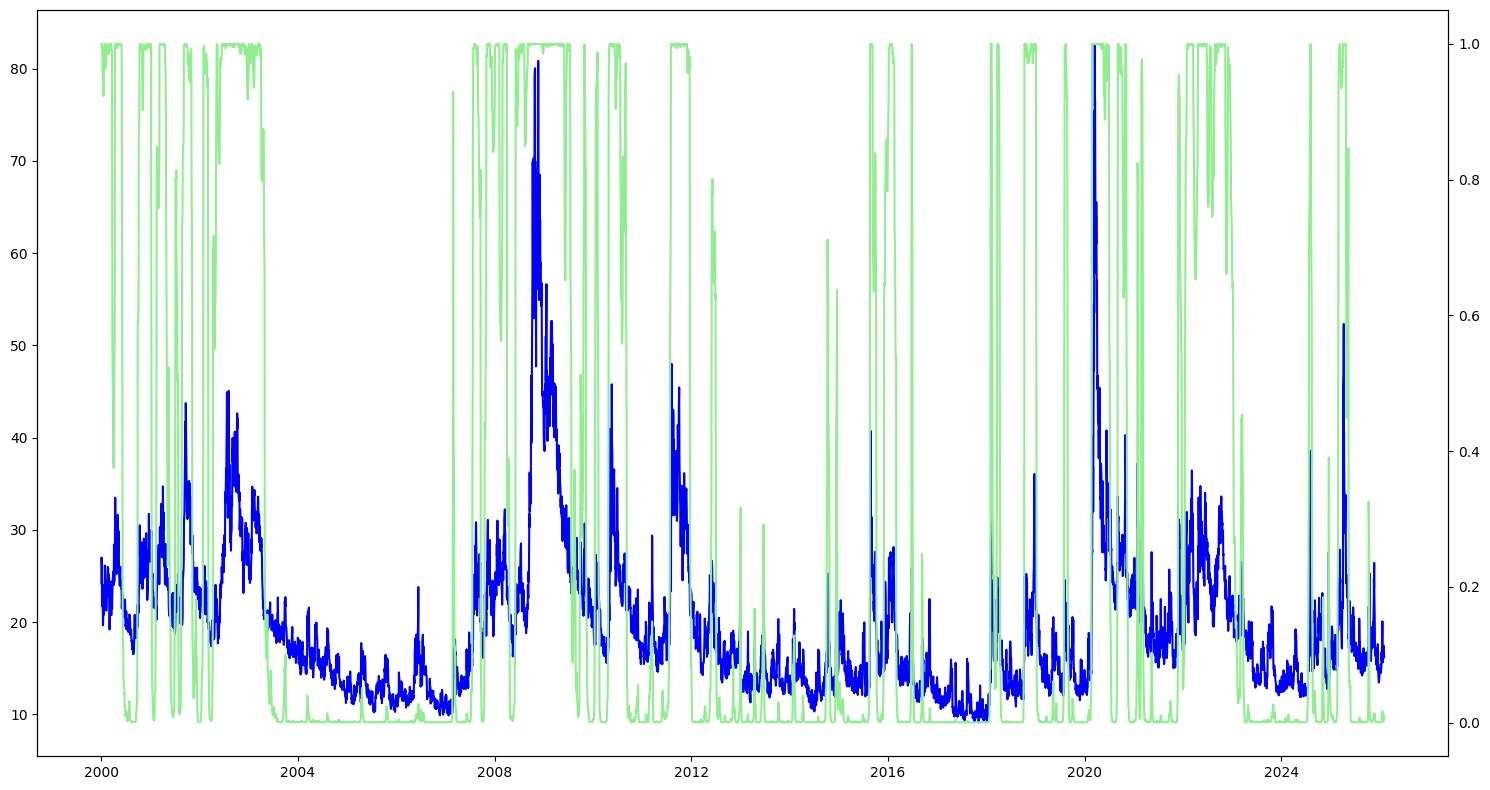

In [25]:

fig, ax1 = plt.subplots(figsize=(15,8))
ax1.plot(vix.Close, label='vix', color='blue')
ax2 = ax1.twinx()
ax2.plot(res.smoothed_marginal_probabilities[1], label='second regime', color='lightgreen')
fig.tight_layout()
plt.show()